%md
<div class="alert alert-block alert-info">
<center> <h1> Customer Segmentation and Sales Forecast</h1> </center> <br>
<center> Big Data Analytics 2025</center><br>
<center> NOVA IMS MDSAA</center>

### [NOTE]
In this project, we are going to work on 4 notebooks:
- 1. **Data Preprocessing**: For EDA, Data Preprocessing, Creating DataFrames, and Feature Engineering
- 2. **Clustering**: For Clustering 
- 3. **Sales Forecasting**: For Sales Forecast
- 4. **Graph**: For Graph Visualization for Clusters<br>
##### **This notebook is 4. Graph.**

%md
# Group 77

|   | Student Name         
|---|-----------------------
| 1 | Hassan Bhatti       
| 2 | Moeko Mitani           
| 3 | Oumayma Ben Hfaiedh    
| 4 | Ricardo Pereira      

# 1. Data Integration 

## 1.1. Import Libraries

In [0]:
%pip install networkx
%pip install matplotlib

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install scipy==1.12.0

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-dabe1b8f-1e4e-4222-a656-d30354fe2127
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Not uninstalling scipy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-dabe1b8f-1e4e-4222-a656-d30354fe2127
    Can't uninstall 'scipy'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
# ─────────────────────────────────────────────
# Spark Core
# ─────────────────────────────────────────────
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, lit, to_timestamp, to_date, year, month, dayofmonth,
    count, countDistinct, sum, avg, min, max,
    round, when, datediff, current_date, concat_ws,
    monotonically_increasing_id
)
from pyspark.sql.functions import max as spark_max

# ─────────────────────────────────────────────
# Spark MLlib
# ─────────────────────────────────────────────
from pyspark.ml.feature import (
    VectorAssembler, PCA, StringIndexer, StandardScaler,
    MinMaxScaler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# ─────────────────────────────────────────────
# Python Built-ins and Data Science Libraries
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import (
    silhouette_samples, silhouette_score,
    confusion_matrix
)

# ─────────────────────────────────────────────
# Utilities
# ─────────────────────────────────────────────
from itertools import combinations

# ─────────────────────────────────────────────
# Graph
# ─────────────────────────────────────────────
import networkx as nx

In [0]:
# Start Spark session
spark = SparkSession.builder.appName("Project_Group77").getOrCreate()

## 1.2. Import CSV File (from previous Notebook: 2. Clustering)

In [0]:
# File location and type
file_location = "/FileStore/df_final.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_final = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df_final.limit(10).display()
df_final.schema


Customer ID,num_invoices,num_products,total_quantity,total_price,avg_unit_price,first_purchase_date,last_purchase_date,purchase_span_days,avg_quantity_per_invoice,recency_days,2022-12,2023-1,2023-10,2023-11,2023-12,2023-2,2023-3,2023-4,2023-5,2023-6,2023-7,2023-8,2023-9,2024-1,2024-10,2024-11,2024-12,2024-2,2024-3,2024-4,2024-5,2024-6,2024-7,2024-8,2024-9,prediction
13285,6,182,2457,3364.59,2.33,2023-03-25,2024-11-16,602,409.5,23,0,0,0,0,0,0,21,23,0,0,0,0,0,0,0,50,0,52,0,30,0,0,55,0,0,1
14570,3,64,431,613.75,3.29,2023-09-22,2024-03-04,164,143.67,280,0,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0,0,0,29,0,0,0,0,0,0,2
15846,1,27,79,107.01,1.82,2023-11-19,2023-11-19,0,79.0,386,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
25462,1,158,278,1281.03,6.11,2024-05-24,2024-05-24,0,278.0,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158,0,0,0,0,1
17420,8,43,444,943.68,3.41,2023-11-03,2024-10-20,352,55.5,50,0,0,0,22,7,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,14,0,0,0,1
24171,1,13,22,43.25,2.49,2024-03-18,2024-03-18,0,22.0,266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,2
16386,3,127,700,1068.16,2.05,2023-11-17,2024-11-11,360,233.33,28,0,0,0,58,0,0,0,0,0,0,0,0,0,0,0,77,0,0,4,0,0,0,0,0,0,1
18024,3,21,148,236.78,2.66,2024-07-10,2024-07-10,0,49.33,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,1
15727,15,426,5908,9371.71,3.57,2023-01-24,2024-11-23,669,393.87,16,0,99,0,50,66,0,0,0,87,13,116,19,0,32,0,39,0,0,0,46,14,0,30,74,0,1
16339,1,17,21,94.05,4.96,2024-02-28,2024-02-28,0,21.0,285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,2


Out[3]: StructType([StructField('Customer ID', IntegerType(), True), StructField('num_invoices', IntegerType(), True), StructField('num_products', IntegerType(), True), StructField('total_quantity', IntegerType(), True), StructField('total_price', DoubleType(), True), StructField('avg_unit_price', DoubleType(), True), StructField('first_purchase_date', DateType(), True), StructField('last_purchase_date', DateType(), True), StructField('purchase_span_days', IntegerType(), True), StructField('avg_quantity_per_invoice', DoubleType(), True), StructField('recency_days', IntegerType(), True), StructField('2022-12', IntegerType(), True), StructField('2023-1', IntegerType(), True), StructField('2023-10', IntegerType(), True), StructField('2023-11', IntegerType(), True), StructField('2023-12', IntegerType(), True), StructField('2023-2', IntegerType(), True), StructField('2023-3', IntegerType(), True), StructField('2023-4', IntegerType(), True), StructField('2023-5', IntegerType(), True), Struct

# 2. Graph

We are going to create a graph for clusters. It helps visually explore relationships and structures in our data.

In [0]:
# Create DataFrame for graph with 'Customer ID' and 'prediction'
df_graph = df_final.select("Customer ID", "prediction")

df_graph.limit(10).display()
df_graph.schema

Customer ID,prediction
13285,1
14570,2
15846,2
25462,1
17420,1
24171,2
16386,1
18024,1
15727,1
16339,2


Out[4]: StructType([StructField('Customer ID', IntegerType(), True), StructField('prediction', IntegerType(), True)])

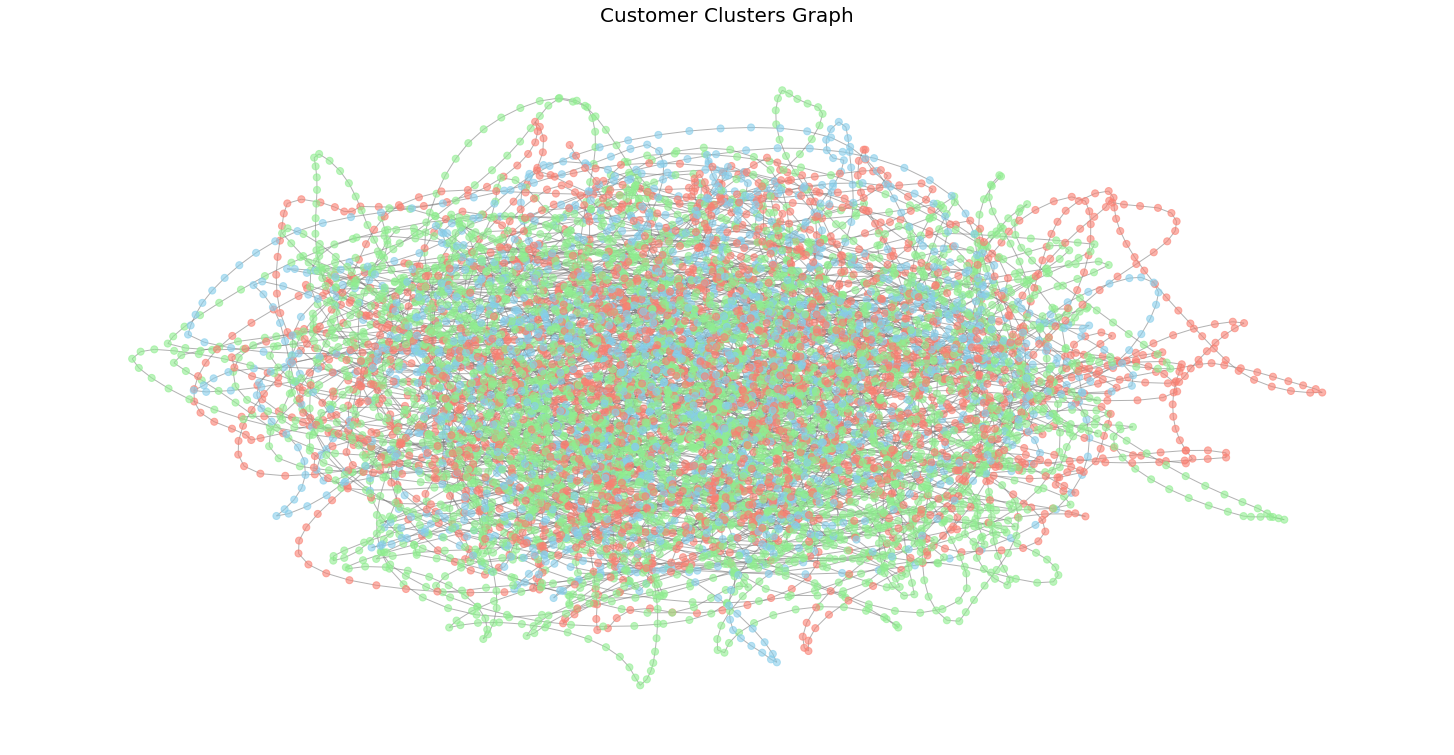

In [0]:
# Convert to Pandas for data manipulation and analysis
pdf_graph = df_graph.toPandas()

# Create a single graph
G = nx.Graph()

# Add customer nodes with cluster attribute
for _, row in pdf_graph.iterrows():
    cust_id = row['Customer ID']
    cluster_id = row['prediction']
    G.add_node(cust_id, cluster=cluster_id)

# Add simple edges between customers in the same cluster (chain-like)
for cluster_id in pdf_graph['prediction'].unique():
    cluster_members = pdf_graph[pdf_graph['prediction'] == cluster_id]['Customer ID'].tolist()
    for i in range(len(cluster_members) - 1):
        G.add_edge(cluster_members[i], cluster_members[i + 1])

# Set cluster colors
cluster_colors = {
    0: 'skyblue',
    1: 'lightgreen',
    2: 'salmon'
}

# Map node colors based on cluster attribute
node_colors = [cluster_colors[G.nodes[node]['cluster']] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=50,
    edge_color='gray',
    alpha=0.6
)
plt.title("Customer Clusters Graph", fontsize=20)
plt.show()


# 3. Observation

#### 1. Cluster Distribution
The colors (nodes) are spread out across the graph, but it can be still seen that groups of same colored nodes sticking together. This suggests that the clustering algorithm found meaningful patterns, even if the graph is dense.

#### 2. Cluster Separation
Red, green, and blue dominate in some areas, which means that the model has found customers with distinct behaviors. However, because the graph is connected at many edges, clusters may be interrelated or slightly overlapping, which could be normal in customer behavior.

#### 3. Outliers and Bridges
Nodes that are isolated or on the edges could be outliers (unusual customer behavior) or “Bridge customers” connecting the two clusters (may be transitional or seasonal behavior).

#### 4. Graph Density
The middle is very dense, meaning there are a lot of similar customers. It could indicate many customers with similar behavior.

## Summary

| Observation | Detail |
|-------------|--------|
| Dense center |	Majority of customers share common behavior |
| Some overlap across colors | Slight similarities across customer groups |
| Sparse areas / edge nodes	| Outliers or niche customer segments |